# Παραδοτέο 1

Παρακάτω φαίνεται το plot της συνάρτησης και τα τοπικά και ολικά ελάχιστά της. 

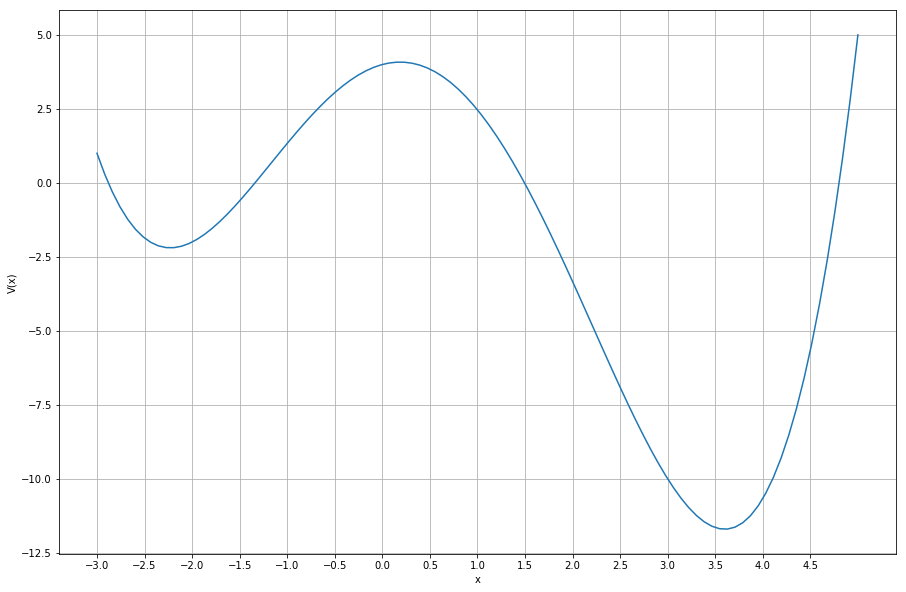

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2017)  # for reproducibility

%matplotlib inline

def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -3/10, -101/45, 13/15, 4.0), x)

x = np.linspace(-3, 5, 100)


plt.figure(figsize = (15, 10))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.xticks(np.arange(-3, 5, 0.5))
plt.grid(True)
plt.show()

Παρατηρείται ότι η ελάχιστη τιμή της συνάρτησης βρίσκεται στο 3.6. 

In [56]:
def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

count = 0

print('Number of successes is ')
for i in range(200):
    T_start, T_end = 2.0, 2**(-12)
    cool_sch, cool_factor = 100, 0.99

    path = sim_anneal(V, -4.5, 4.5, delta = 1.,
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest

    path[-1]  # last position
    if (np.fabs(path[-1]-3.6) < 0.05):
        count = count+1

print(count)
print('Percentage of wrong estimations')
print((200-count)/2)

Number of successes is 
200
Percentage of wrong estimations
0.0


Το ολικό ελάχιστο έχει μεγάλη απόκλιση από τα τοπικά ελάχιστα. Για αυτό το λόγο, ο αλγόριθμος το εντοπίζει με 100% επιτυχία μέσω simulated annealing.

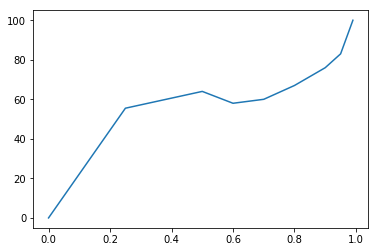

In [50]:
x = []
y = []

x.append(0.0)
y.append(0.0)

for cool_factor in [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
    count = 0
    for i in range(200):
        T_start, T_end = 2.0, 2**(-12)
        cool_sch = 100

        path = sim_anneal(V, -4.5, 4.5, delta = 1.,
                 T = T_start, T_min = T_end, cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest

        path[-1]  # last position

        x.append(cool_factor)
        
        if (np.fabs(path[-1]-3.6) < 0.05):
            count = count+1
    print (count)
    y.append(count*100/200)
 

plt.plot(x,y)
plt.show()



# Παραδοτέο 2

Παρακάτω τροποποιούμε τις διάφορες παραμέτρους του αλγορίθμου, και εξετάζουμε ποιές έδωσαν τα καλύτερα αποτελέσματα σχετικά με το μήκος μονοπατιού του TSP.

Temp 100, Temp_end 0.020, cool_factor 0.95 , cool_schedule 100.00
Improvement:	      61%
Initial distance:	60608 km
Optimal distance:	23439 km


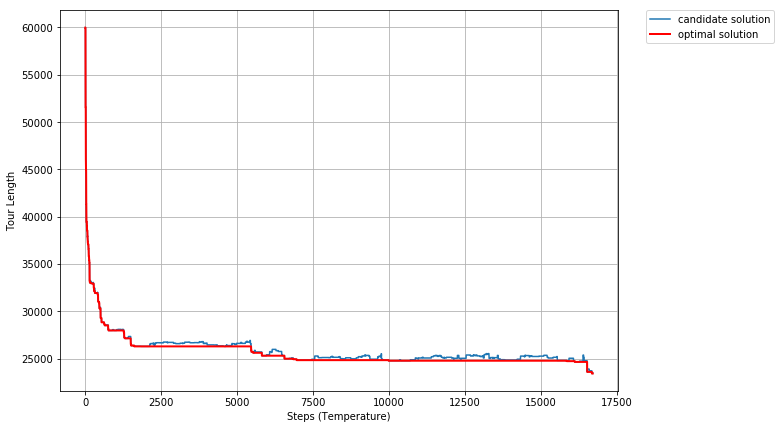

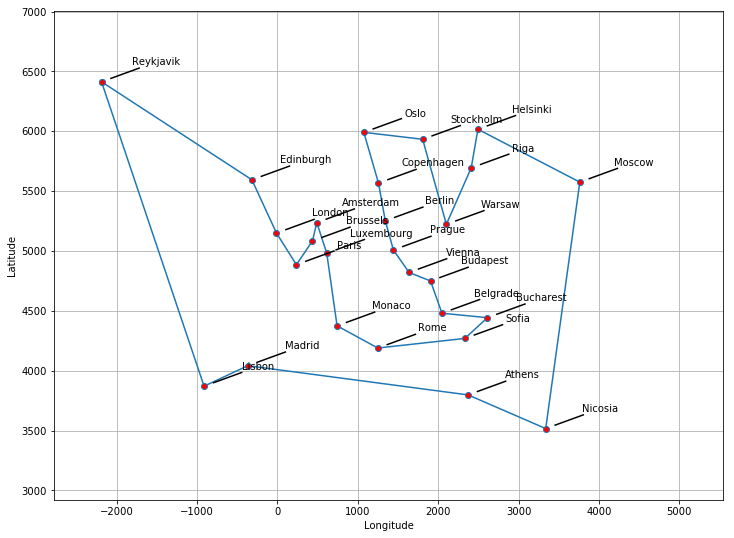

Temp 10000000, Temp_end 0.070, cool_factor 0.95 , cool_schedule 100.00
Improvement:	      34%
Initial distance:	60608 km
Optimal distance:	39970 km


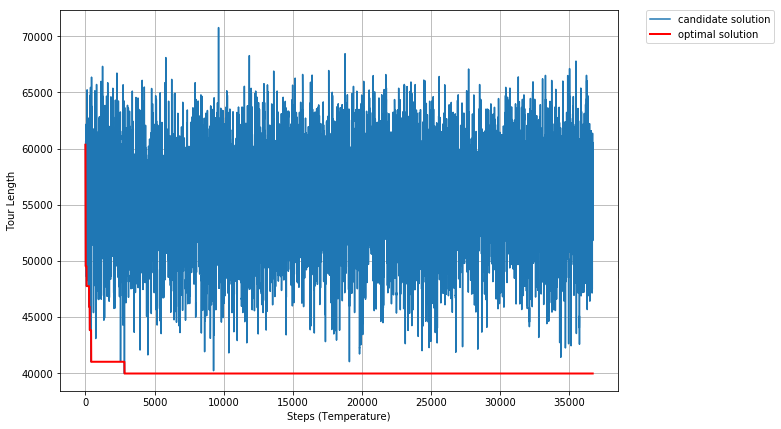

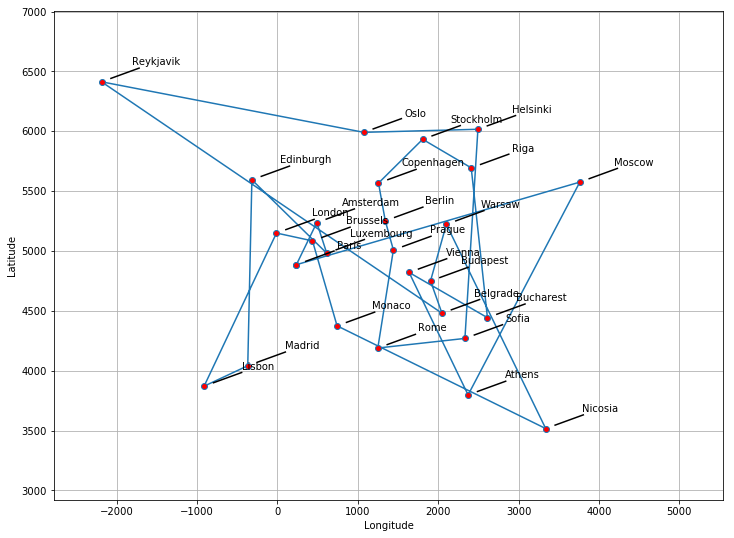

Temp 10000000, Temp_end 0.020, cool_factor 0.99 , cool_schedule 100.00
Improvement:	      39%
Initial distance:	60608 km
Optimal distance:	37167 km


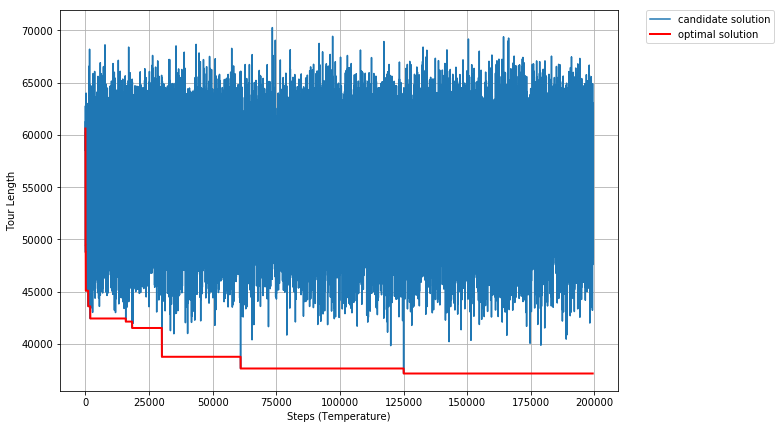

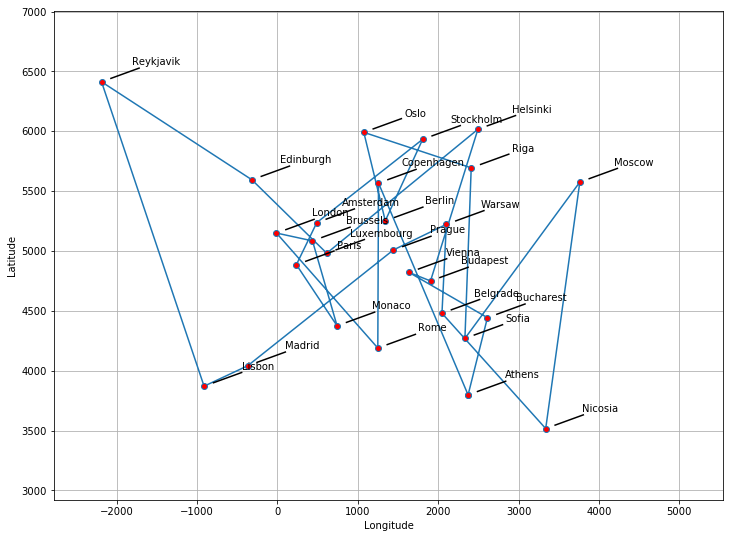

Temp 10000000, Temp_end 0.020, cool_factor 0.95 , cool_schedule 160.00
Improvement:	      37%
Initial distance:	60608 km
Optimal distance:	38423 km


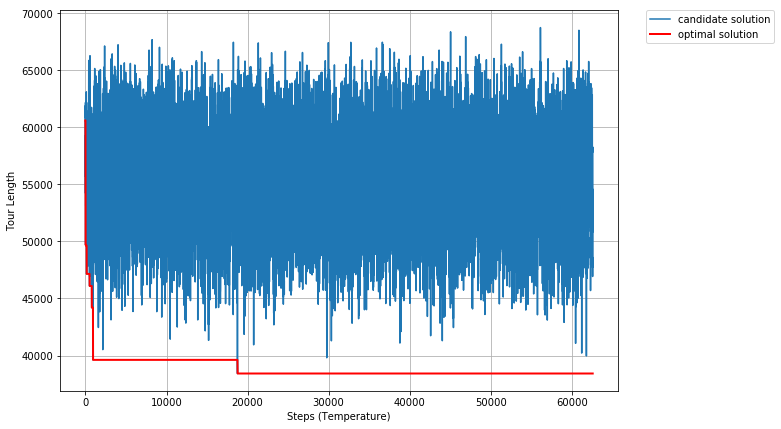

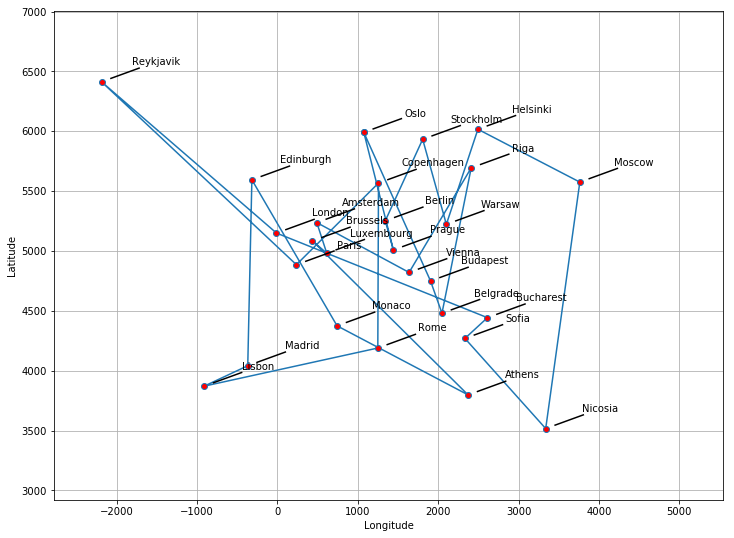

In [34]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv"

with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())

def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r


# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

    
def tsp (Temp, Temp_end, cool_factor, cool_schedule):
    short = 100000

    Temp_0 = Temp
    # Bookeeping parameters
    tour = np.arange(Ncities)  # initial permutation
    tour_length = total_dist(tour)  # initial energy level

    shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
    shortest_tour_length = tour_length  # shortest distance

    # To plot later
    first_guess = tour_length
    running_lengths = []
    optimal_lengths = []

    # Main loop
    while Temp_0 > Temp_end:
        # Constant Temperature Era
        for step in range(cool_schedule):
            # Choose 2 cities to swap
            B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
            ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
            XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

            # Compute the energy diffence  
            diff = dist_diff(ABC, XYZ, tour)
        
            # Decide whether to change state.
            if np.log(np.random.rand()) < -diff / Temp:
                tour[B], tour[Y] = tour[Y], tour[B]
                tour_length += diff
                # Keep track of the optimal tour observed
                if tour_length < shortest_tour_length:
                    shortest_tour = np.copy(tour)
                    shortest_tour_length = tour_length

            running_lengths.append(tour_length)
            optimal_lengths.append(shortest_tour_length)

        Temp_0 *= cool_factor  # cool down

   
    print('Temp %d, Temp_end %.3f, cool_factor %.2f , cool_schedule %.2f' % (Temp, Temp_end, cool_factor, cool_schedule))
    print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
    print('Initial distance:\t%.0f km'  % first_guess)
    print('Optimal distance:\t%.0f km'  % shortest_tour_length)
                
    if (shortest_tour_length < short):
        short = shortest_tour_length
        impro = (100 * (first_guess - shortest_tour_length) / first_guess)
        x_a = Temp
        x_b = Temp_end
        x_c = cool_factor
        x_d = cool_schedule

    running_lengths = np.array(running_lengths)
    optimal_lengths = np.array(optimal_lengths)

    plt.figure(figsize = (10, 7))
    plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
    plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

    plt.xlabel("Steps (Temperature)")
    plt.ylabel("Tour Length")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()

    plt.show()
    
    plt.figure(figsize=(12, 9))  # increase image size

    # Get Tour Coordinates
    coord = np.array([city_coord[city] for city in city_names])
    cities = shortest_tour.copy()
    cities = np.append(cities, cities[0])
    coord = coord[cities,:]  # rearrange

    # Scale for better readability
    scale_factor = 100
    coord = coord * scale_factor

    # Plot Tour
    plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()

    # Manage spacing
    spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
    plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
    plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

    # Add labels - remove for more clear picture
    if len(cities)<=30:
        for i, city in enumerate(cities[:-1]):
            plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city],
                 withdash = True,
                 dashdirection = 1,
                 dashlength = 30,
                 rotation = 0,
                 dashrotation = 20,
                 dashpush = 10)
    plt.show()

tsp(10**2,0.02,0.95, 100)
tsp(10**7, 0.07, 0.95, 100)
tsp(10**7,0.02,0.99, 100)
tsp(10**7,0.02,0.95, 160)




### Ερώτημα Α
Παρατηρούμε ότι μεταβάλοντας τη θερμοκρασία, για τιμές όπως $10$ ή $10^2$ τα αποτελέσματα ήταν καλύτερα, και χειροτέρευε το improvement και αυξανόταν το μήκος μονοπατιού όσο αυξανόταν η θερμοκρασία. Οπότε η optimal λύση είναι για $Temp = 100, path = 25339$. 
Αύξηση του Temp_end δίνει τοπικά ελάχιστα για τις τιμές 0.2, 0.3 και ολικό ελάχιστο για την τιμή 0.7 και από εκείνη την τιμή έως και 1.0 που δοκιμάσαμε τα αποτελέσματα ήταν ελαφρώς μικρότερα από το 0.2. 
Αύξηση του cool_factor, μέχρι τη μέγιστη τιμή 0.99, βελτιώνει το improvement και το μονοπάτι. Έτσι, τα καλύτερα αποτελέσματα παρατηρήθηκαν για cool_factor = 0.99.
Μεταβολή του cooling_schedule έδωσε καλύτερα όσο αυξανόταν, με μικρές όμως βελτιώσεις, από 10 έως 250. Η βέλτιστη τιμή παρατηρήθηκε για cool_schedule = 160. 

### Ερώτημα Β
Παρακάτω φαίνονται τα αποτελέσματα για το νέο αρχείο εισόδου με τις 50 πόλεις, μαζί με τα αντίστοιχα plots. 

Temp 10000000, Temp_end 0.020, cool_factor 0.95 , cool_schedule 100.00
Improvement:	      24%
Initial distance:	100118 km
Optimal distance:	76401 km


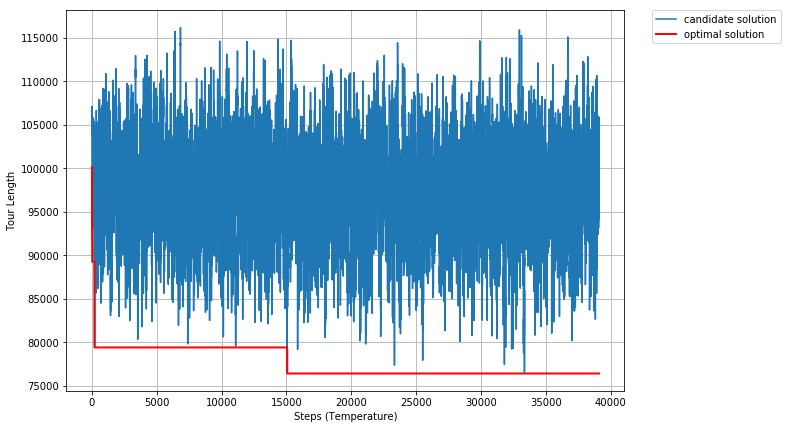

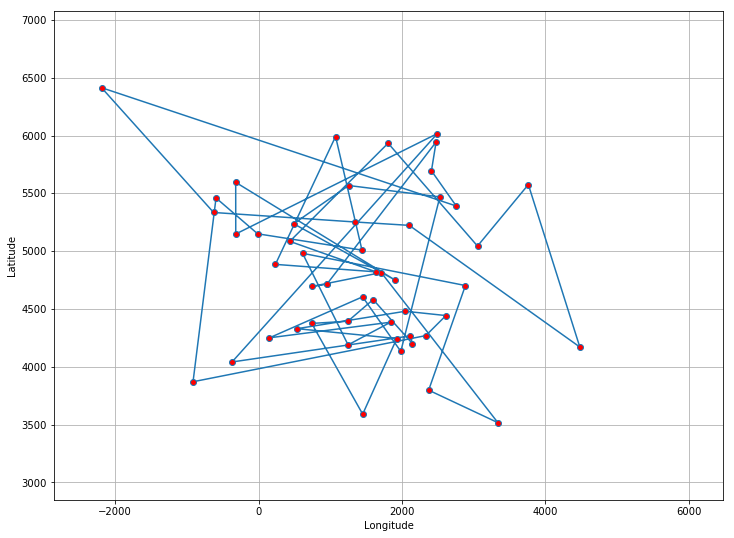

In [37]:
url = "http://math.ntua.gr/~loulakis/info/python_codes_files/europe.csv"


with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())

def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r


# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

    
def tsp_2 (Temp, Temp_end, cool_factor, cool_schedule):
    short = 100000

    Temp_0 = Temp
    # Bookeeping parameters
    tour = np.arange(Ncities)  # initial permutation
    tour_length = total_dist(tour)  # initial energy level

    shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
    shortest_tour_length = tour_length  # shortest distance

    # To plot later
    first_guess = tour_length
    running_lengths = []
    optimal_lengths = []

    # Main loop
    while Temp_0 > Temp_end:
        # Constant Temperature Era
        for step in range(cool_schedule):
            # Choose 2 cities to swap
            B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
            ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
            XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

            # Compute the energy diffence  
            diff = dist_diff(ABC, XYZ, tour)
        
            # Decide whether to change state.
            if np.log(np.random.rand()) < -diff / Temp:
                tour[B], tour[Y] = tour[Y], tour[B]
                tour_length += diff
                # Keep track of the optimal tour observed
                if tour_length < shortest_tour_length:
                    shortest_tour = np.copy(tour)
                    shortest_tour_length = tour_length

            running_lengths.append(tour_length)
            optimal_lengths.append(shortest_tour_length)

        Temp_0 *= cool_factor  # cool down

   
    print('Temp %d, Temp_end %.3f, cool_factor %.2f , cool_schedule %.2f' % (Temp, Temp_end, cool_factor, cool_schedule))
    print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
    print('Initial distance:\t%.0f km'  % first_guess)
    print('Optimal distance:\t%.0f km'  % shortest_tour_length)
                
    if (shortest_tour_length < short):
        short = shortest_tour_length
        impro = (100 * (first_guess - shortest_tour_length) / first_guess)
        x_a = Temp
        x_b = Temp_end
        x_c = cool_factor
        x_d = cool_schedule

    running_lengths = np.array(running_lengths)
    optimal_lengths = np.array(optimal_lengths)

    plt.figure(figsize = (10, 7))
    plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
    plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

    plt.xlabel("Steps (Temperature)")
    plt.ylabel("Tour Length")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()

    plt.show()
    
    plt.figure(figsize=(12, 9))  # increase image size

    # Get Tour Coordinates
    coord = np.array([city_coord[city] for city in city_names])
    cities = shortest_tour.copy()
    cities = np.append(cities, cities[0])
    coord = coord[cities,:]  # rearrange

    # Scale for better readability
    scale_factor = 100
    coord = coord * scale_factor

    # Plot Tour
    plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()

    # Manage spacing
    spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
    plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
    plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

    # Add labels - remove for more clear picture
    if len(cities)<=30:
        for i, city in enumerate(cities[:-1]):
            plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city],
                 withdash = True,
                 dashdirection = 1,
                 dashlength = 30,
                 rotation = 0,
                 dashrotation = 20,
                 dashpush = 10)
    plt.show()

tsp_2(10**7, 0.02, 0.95, 100)

### Ερώτημα Γ
1. Τα πιθανά μονοπάτια που περνούν μια φορά από κάθε κόμβο του γράφου, αν ο γράφος έχει $n=35$ κόμβους είναι $\frac{(n-1)!}{2}$. Αυτός δηλαδή είναι ο αριθμός πιθανών μεταθέσεων των κόμβων, που αντιπροσωπεύει τη σειρά με την οποία διέρχεται από αυτούς ο αλγόριθμος του TSP. Η διαίρεση δια δύο γίνεται διότι το γράφημα είναι undirected, και συνεπώς οι δύο διασχίσεις του ίδιου μονοπατιού ταυτίζονται. Επιπλέον, αντί για $n!$ έχουμε $(n-1)!$ καθώς δεν έχει σημασία η πόλη από την οποία ξεκινάμε τον αλγόριθμο. Άρα συνολικά 1.476164e+38 μονοπάτια.

2. Με την brute force εκτέλεση, προφανώς εξετάζουμε όλα τα πιθανά μονοπάτια που περνούν από κάθε κόμβο ακριβώς μια φορά, δηλαδή απαιτείται χρόνος $\frac{(n-1)!}{2}\times 1$ μsec = $1.476164e+38$ μsec.